In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

Let's read the json file and make the dataframe and look at some basic statistics.

In [121]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [122]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


It appears that there are some null values in the ratings and the phone. I am going to fill these null ratings values with the mean of those columns, but the phone column has no mean so I will not fill it and instead drop those null values.

In [124]:
df = df.drop(df[df.phone.isna() ==  True].index, axis=0)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


I want to find the date of the last ride.

In [126]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['last_trip_date'].describe(datetime_is_numeric=True)

count                            49604
mean     2014-04-19 11:13:41.836948480
min                2014-01-01 00:00:00
25%                2014-02-14 18:00:00
50%                2014-05-08 00:00:00
75%                2014-06-18 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

It appears the last data point is July 1st, therefore retained users are those who took a trip after June 1st, I will make a boolean column that is True if the user took a ride after June 1st and false otherwise.

In [127]:
df['retained_user'] = [last_trip_date > pd.to_datetime('2014-06-01') for last_trip_date in df.last_trip_date]
df['retained_user'].value_counts()

False    31424
True     18180
Name: retained_user, dtype: int64

In [128]:
df['retained_user'].sum() / len(df)

0.3665027013950488

It appears that 36.6% of users are considered retained.

In [129]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
 12  retained_user           49604 non-null  bool  

Let's take a look at the popularity of this app within the different cities in the dataset.

Text(0, 0.5, 'Total Trips')

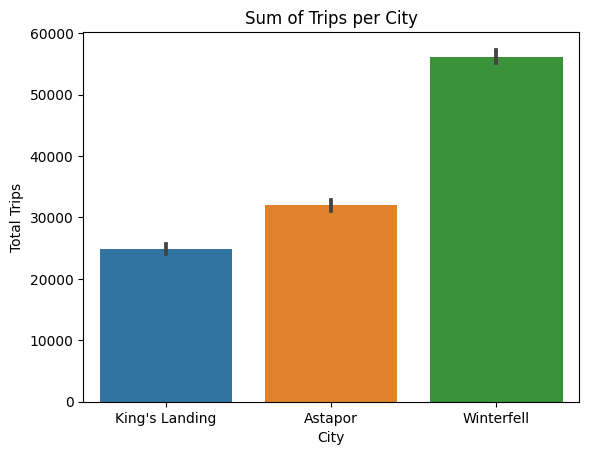

In [131]:
sns.barplot(x='city', y='trips_in_first_30_days', data=df, estimator=sum)
plt.title('Sum of Trips per City')
plt.xlabel('City')
plt.ylabel('Total Trips')

It appears that most trips took place in Winterfell, with a little more than half that number in Astapor, and even fewer than King's Landing. Now let's examine the popularity of each phone.

Text(0, 0.5, 'Total Trips')

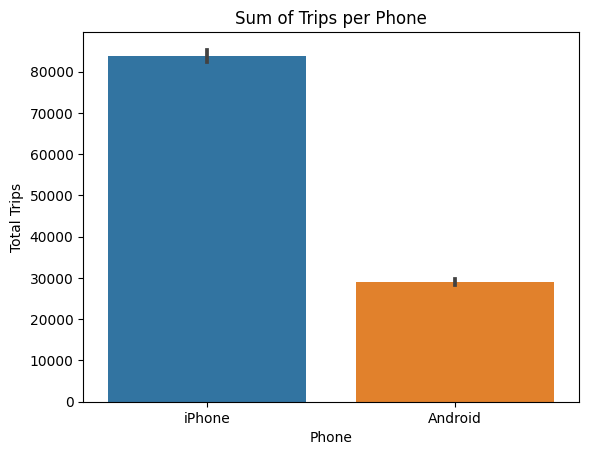

In [132]:
sns.barplot(x='phone', y='trips_in_first_30_days', data=df, estimator=sum)
plt.title('Sum of Trips per Phone')
plt.xlabel('Phone')
plt.ylabel('Total Trips')

The iPhone is much more popular than the Android, now let's look at these categories effects on the retaining of users.

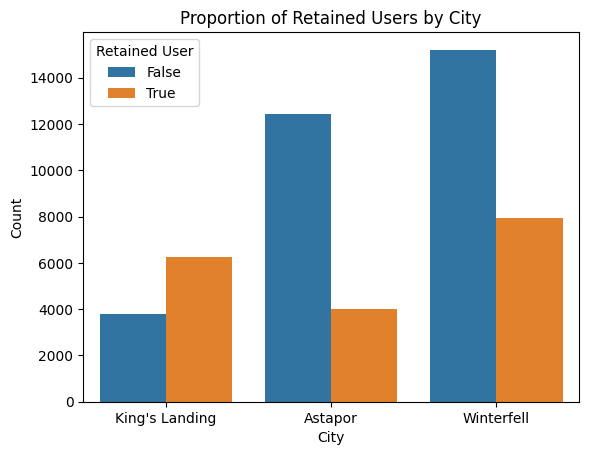

In [133]:
sns.countplot(data=df, x='city', hue='retained_user')
plt.title('Proportion of Retained Users by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.legend(title='Retained User')

It's seems that King's Landing, while being where use of the app is least common, is also most likely to create a retained user, and Astapor is least likely.

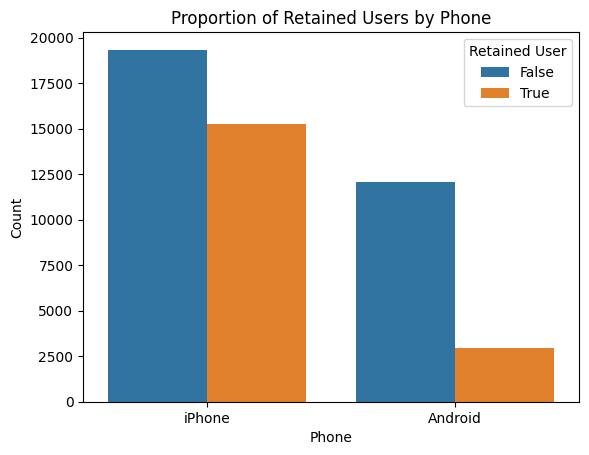

In [134]:
sns.countplot(data=df, x='phone', hue='retained_user')
plt.title('Proportion of Retained Users by Phone')
plt.xlabel('Phone')
plt.ylabel('Count')
plt.legend(title='Retained User')

The iPhone clearly is more likely to retain users than the Android phones. Now let's make a model, I will begin by droping the datetime columns, then converting the retained_user column to a numeric one, and dropping it for the rest of the dataframe.

In [135]:
df = df.drop(columns=['signup_date', 'last_trip_date'])
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_user
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,False


In [136]:
y = pd.DataFrame(np.where(df['retained_user'] == True, 1, 0), columns=['retained_user'])
y.head()

,retained_user
0,1
1,0
2,0
3,1
4,0


In [137]:
df = df.drop(columns=['retained_user'])
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9


Now I will convert the categorical columns to dummy columns, and create an xgbclassifier model. I tested various types of classifiers and xgboost was the most accurate one.

In [138]:
df = pd.get_dummies(df, columns=['city', 'phone', 'ultimate_black_user'])
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


In [139]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=47)

In [140]:
xgbmodel = xgb.XGBClassifier()

grid_params = {
    'learning_rate' : (0.05, 0.10),
    'n_estimators' : [300, 400, 500]
}

xgb_grid_cv = GridSearchCV(xgbmodel, param_grid=grid_params, cv=5, n_jobs=-1)
xgb_grid_cv.fit(X_train, y_train)
print(xgb_grid_cv.best_params_)

{'learning_rate': 0.05, 'n_estimators': 400}


In [141]:
y_pred = xgb_grid_cv.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[6807 1056]
 [1504 3034]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      7863
           1       0.74      0.67      0.70      4538

    accuracy                           0.79     12401
   macro avg       0.78      0.77      0.77     12401
weighted avg       0.79      0.79      0.79     12401



Our models successfully predicts whether a user will be retained with almost 80% accuracy.

<AxesSubplot:>

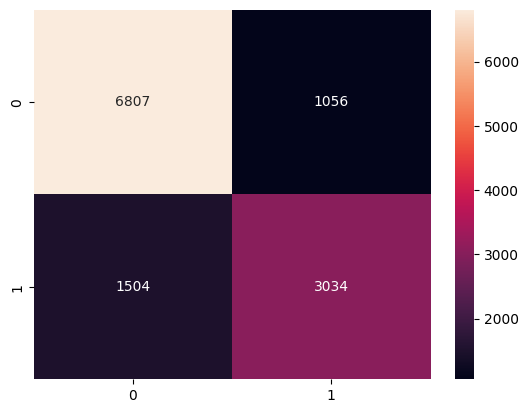

In [142]:
sns.heatmap(cm, annot=True, fmt='g')

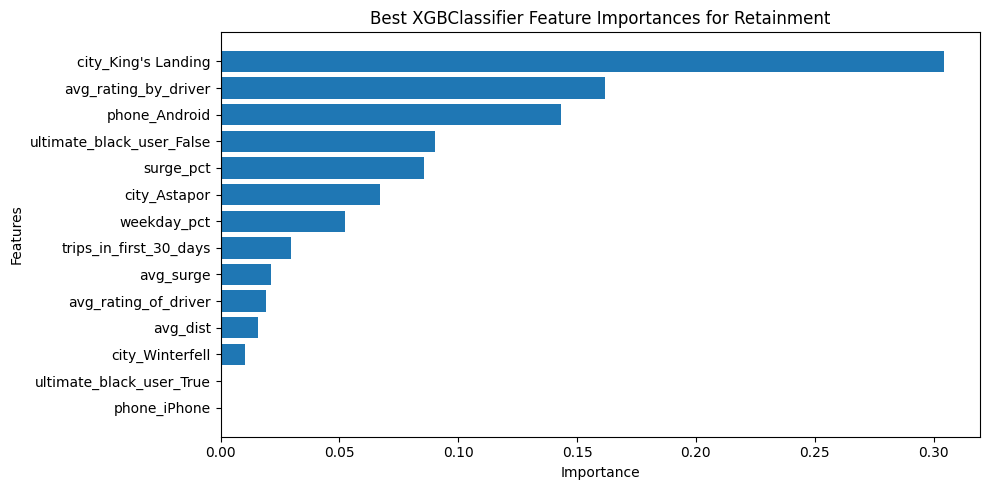

In [143]:
sorted_index = xgb_grid_cv.best_estimator_.feature_importances_.argsort()

plt.subplots(figsize=(10, 5))
plt.barh(X_train.columns[sorted_index], xgb_grid_cv.best_estimator_.feature_importances_[sorted_index])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Best XGBClassifier Feature Importances for Retainment')
plt.tight_layout()

Looking at the feature importance when creating the model, it appears that the user's presence in King's Landing is highly important in the model's decision making. We saw earlier that King's Landing was the city with the least number of uses, but also the highest retention rate. Ultimate cannot control where their users come from, but it may be worth while to look at demographic or geographical differences between the cities, to see if public density, or class, or race or other factors that make the cities different play a role.

After that comes average rating by the driver; it is unlikely that users know that rating, so it is difficult to make a recommendation based on it. We saw that Android users were much less likely to be retained, perhaps the experience on that version of the app is more negative than that on the iPhone, so perhaps Ultimate should look into redeveloping that version of the app.

My main recommendation would be to redevelop the Android version of the Ultimate app.